# Code for Optimal 1D K-Means with Dynamic Programming

## Imports and Helping Functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import functools
from collections import deque
from sklearn.cluster import KMeans
plt.style.use("ggplot")

def plot_data(data, cluster_indeces=None, title=None):
    """
    This function plots the 1D points.
    If cluster_indeces are provided, they are used to color the points.
    """
    plt.figure(figsize=(10, 1))
    if title:
        plt.title(title, fontsize=16)
    plt.plot([-2, np.max(data)+2], [0, 0], "--", c="blue")
    if cluster_indeces is not None:
        plt.scatter(data, [0] * len(data), 
                    marker="x", s=150, c=cluster_indeces, cmap="tab10")
    else:
        plt.scatter(data, [0] * len(data), 
                    marker="x", s=150, c="red")
    plt.xlim(left=-1, right=np.max(data)+1)
    ax = plt.gca()
    ax.get_yaxis().set_visible(False)
    plt.show()


def order_clusters_indicies(clusters):
    """
    This functions puts the cluster labels in the increasing order.
    Example input:  [1,1,1,0,0,0,0,3,3,2,2,2]
    Example output: [0,0,0,1,1,1,1,2,2,3,3,3]
    """
    order = []
    for c in clusters:
        if c not in order:
            order.append(c)
    to_order = dict(zip(order, range(len(order))))
    return np.vectorize(to_order.get)(clusters)

## Naive Implementation

### DP

In [2]:
def CC(x):
    m = np.mean(x)
    d = (x - m)**2
    return np.sum(d)


def Kmeans1D(X, k):
    n = len(X)
    if k>n:
        raise ValueError("Number of clusters can't be higher then number of points!")
    D = np.zeros((k, n))
    T = np.zeros((k, n))

    # Filling first row of D
    for m in range(n):
        D[0, m] = CC(X[0:m+1])
    
    # Filling the rest rows
    for i in range(1, k):
        for m in range(i, n):
            D_ms = np.array([0.0] + [D[i-1, j-1] for j in range(1, m)])
            CC_ms = np.array([CC(X[j:m+1]) for j in range(m)])
            ms = D_ms + CC_ms
            D[i, m] = np.min(ms)
            T[i, m] = np.argmin(ms)
    
    return D, T.astype(int)

### Backtracking

In [3]:
def Backtrace(T):
    k, n = T.shape
    m = n - 1

    # Find the borders of clusters
    cluster_borders = deque()
    for i in range(k-1, -1, -1):
        m = T[i, m]
        cluster_borders.appendleft(m)
    cluster_borders.append(n)

    # Create an array of length n where ith element is assigned to cluser
    clusters = np.array([None] * n)
    l = cluster_borders.popleft()
    c = 0
    while cluster_borders:
        r = cluster_borders.popleft()
        clusters[l:r] = c
        l = r
        c += 1
    return clusters

## Test on data

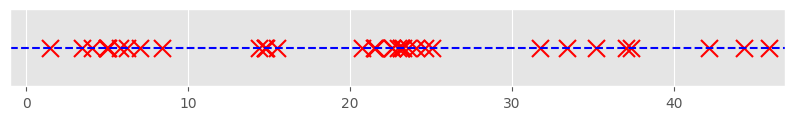

In [4]:
r = np.random.RandomState(7)
data = np.sort(np.concatenate([
    r.normal(loc=5, scale=2, size=10),
    r.normal(loc=15, scale=1, size=5),
    r.normal(loc=23, scale=1, size=15),
    r.normal(loc=40, scale=4, size=8)
]))

plot_data(data)

In [20]:
D, T = Kmeans1D(data, k=4)
dp_labels = Backtrace(T)
dp_obj = np.round(D[-1,-1], 3)

In [21]:
kmeans = KMeans(n_clusters=4, random_state=8, n_init="auto").fit(data.reshape(data.shape[0], 1))
sklearn_labels_1 = order_clusters_indicies(kmeans.labels_)
sklearn_obj_1 = np.round(kmeans.inertia_, 3)

In [22]:
kmeans = KMeans(n_clusters=4, random_state=9, n_init="auto").fit(data.reshape(data.shape[0], 1))
sklearn_labels_2 = order_clusters_indicies(kmeans.labels_)
sklearn_obj_2 = np.round(kmeans.inertia_, 3)

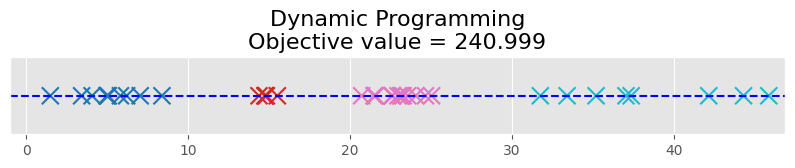

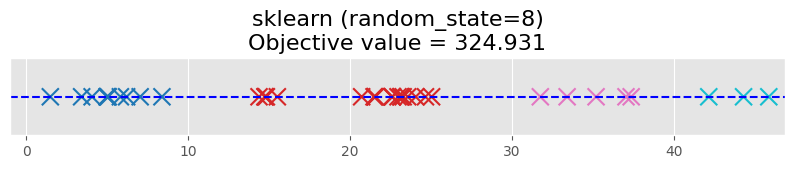

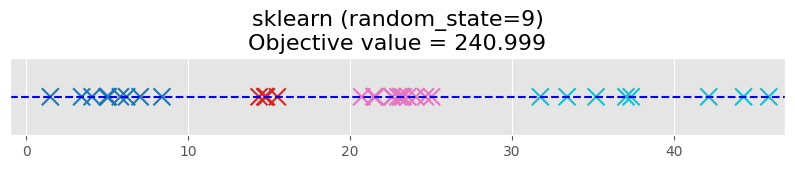

In [23]:
nmaes = [
    f"Dynamic Programming\nObjective value = {dp_obj}", 
    f"sklearn (random_state=8)\nObjective value = {sklearn_obj_1}", 
    f"sklearn (random_state=9)\nObjective value = {sklearn_obj_2}"
]
lables = [dp_labels, sklearn_labels_1, sklearn_labels_2]
for name, lable in zip(nmaes, lables):
    plot_data(data, cluster_indeces=lable, title=name)

## Optimal implementation

### Prefix sums

In [9]:
def sum_from_prefix(prefix_sums: np.array, l: int, r: int):
    """
    This function calculates the sum of values between l and r index
    given the array of prefix sums (value on r index is not included).
    """
    if l == 0:
        return prefix_sums[r - 1]
    return prefix_sums[r - 1] - prefix_sums[l - 1]


def CC_from_prefix(X_sums: np.array, X_sq_sums: np.array, l: int, r: int):
    """
    This function calculates the cost of cluster given the 
    array of prefix sums for X and X squred (value on r index is not included).
    """
    sum_X = sum_from_prefix(X_sums, l=l, r=r)
    sum_X_sq = sum_from_prefix(X_sq_sums, l=l, r=r)
    mu = sum_X / (r - l)
    mu_sq = mu**2
    cc = (r - l) * mu_sq - 2 * mu * sum_X + sum_X_sq
    return cc

### DP

In [10]:
def Kmeans1D_optimised(X, k):
    n = len(X)
    if k>n:
        raise ValueError("Number of clusters can't be higher then number of points!")
    D = np.zeros((k, n))
    T = np.zeros((k, n))

    # Filling the first row of D
    # And computing the prefix sums for X and X**2
    cc_prev = 0
    mu_prev = 0
    X_prefix_sum = np.array([None] * n)
    X_prefix_sum[0] = X[0]
    X_sq_prefix_sum = np.array([None] * n)
    X_sq_prefix_sum[0] = X[0]**2
    for m in range(n):
        cc = cc_prev + (X[m] - mu_prev)**2 * m / (m + 1)
        D[0, m] = cc
        mu_prev = (X[m] + m * mu_prev ) / (m + 1)
        cc_prev = cc

        if m > 0:
            X_prefix_sum[m] = X_prefix_sum[m-1] + X[m]
            X_sq_prefix_sum[m] = X_sq_prefix_sum[m-1] + X[m]**2
    
    # Filling the rest rows
    for i in range(1, k):
        for m in range(i, n):
            D_ms = np.pad(D[i-1, 0:m-1], (1,0))
            CC_ms = np.array([CC_from_prefix(X_prefix_sum, X_sq_prefix_sum, l=j, r=m+1) for j in range(m)])
            ms = D_ms + CC_ms
            D[i, m] = np.min(ms)
            T[i, m] = np.argmin(ms)
    
    return D, T.astype(int)

In [11]:
%%timeit -r 10 -n 200
D, T = Kmeans1D_optimised(data, k=4)

18.4 ms ± 9.51 ms per loop (mean ± std. dev. of 10 runs, 200 loops each)


In [12]:
%%timeit -r 10 -n 200
D, T = Kmeans1D(data, k=4)

47.2 ms ± 11.9 ms per loop (mean ± std. dev. of 10 runs, 200 loops each)


## Example of T usage

In [13]:
X = np.array([1,2,3,12,15,29,32])
D, T = Kmeans1D(X, k=3)
T

array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 2, 3, 3, 5],
       [0, 0, 1, 2, 3, 4, 5]])

In [14]:
dp_labels = Backtrace(T)

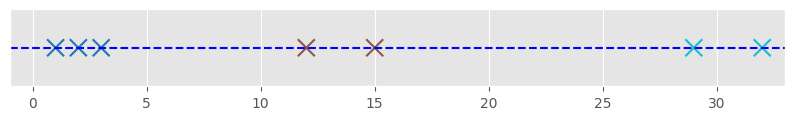

In [15]:
plot_data(X, cluster_indeces=dp_labels)

# References

- Fast Exact k-Means, k-Medians and Bregman Divergence Clustering in 1D ([link](https://arxiv.org/abs/1701.07204))
- Ckmeans.1d.dp: Optimal k-means Clustering in One Dimension by Dynamic Programming ([link](https://journal.r-project.org/archive/2011-2/RJournal_2011-2_Wang+Song.pdf))